In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import gc

%matplotlib inline
pd.options.display.float_format = '{:.5f}'.format

train_columns = ['ip', 'app', 'os', 'device', 'channel', 'click_time', 'is_attributed']
dtypes = { # dizendo manualmente o tipo do dado a ser importado pra economizar memória ram. o padrão seria uint64
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'os'            : 'uint16',
            'device'        : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8'
        }

In [2]:
data_perc = 0.05 # cuidado aqui

# carregando do csv

In [3]:
train_size_total = 184903890
train_size = int(data_perc*train_size_total)

start = time.time()
data_train = pd.read_csv('input/train.csv', nrows=train_size, usecols=train_columns, parse_dates=['click_time'], dtype=dtypes)
print('{:.2f}s to load train data'.format(time.time()-start))

11.05s to load train data


# extraindo features interessantes

* `ip_clicks_on_app_perc`: o percentual de clicks daquele ip naquele aplicativo em relação a todos os clicks daquele ip

* `os_clicks_on_app_perc`: o percentual de clicks daquele os naquele aplicativo em relação a todos os clicks daquele os

* `channel_clicks_on_app_perc`: o percentual de clicks daquele channel naquele aplicativo em relação a todos os clicks daquele channel

* `ip_total_clicks`: o total de clicks feitos por aquele ip

* `ip_total_clicks_on_app`: o total de clicks feitos por aquele ip naquele aplicativo

* `ip_os_total_clicks_on_app`: o total de clicks feitos por aquela combinação de ip e os naquele aplicativo

* `ip_os_total_clicks`: o total de clicks feitos por aquela combinação de ip e os

* `ip_os_clicks_on_app_perc`: o percentual de clicks feitos por aquela combinação de ip e os naquele aplicativo em relação à quantidade total de clicks que aquela combinação de ip e os executou

* `ip_activity_on_app_duration`: o intervalo de tempo em segundos entre o primeiro e o último click daquele ip naquele aplicativo

* `ip_activity_intervals_std`: o desvio padrão dos os intervalos de tempo em segundos entre os clicks daquele ip

* `ip_activity_on_app_duration_perc`: o percentual do tempo que aquele ip passou clickando naquele aplicativo em relação ao tempo total que aquele ip passou clickando

* `os`: originalmente, o id do sistema operacional. mas substituí pelo percentual de downloads daquele sistema operacional em relação a todos os clicks feitos com aquele sistema operacional

* `os`: originalmente, o id do canal[?]. mas substituí pelo percentual de downloads daquele canal em relação a todos os clicks feitos com aquele canal

In [4]:
def get_attributed(obj):
    sm = obj.sum()
    if np.isnan(sm):
        return 0
    return sm

def replace_base_features_by_their_perc(combine, features):
    for feature in features:
        start = time.time()
        total = combine.groupby(feature)[feature].transform('count').astype('uint32')
        attributed = combine.groupby(feature)['is_attributed'].transform(get_attributed)
        combine[feature] = attributed/total
        del total, attributed
        gc.collect()
        print('{:.2f}s to remake feature {}'.format(time.time()-start, feature))

def get_timediff(obj):
    return max(1, (obj.max()-obj.min()).total_seconds())

def get_intervals_std(obj):
    if len(obj)<=2:
        return 1000
    intervals = []
    obj = obj.tolist()
    for i in range(len(obj)-1):
        intervals.append( (obj[i+1] - obj[i]).total_seconds() )
    std = np.array(intervals).std()
    return std

def generate_clicks_on_app_features(combine, features):
    for feature in features:
        derived_feature = feature+'_clicks_on_app_perc'
        start = time.time()
        total_clicks = combine.groupby(feature)[feature].transform('count')
        clicks_on_app = combine.groupby([feature, 'app'])[feature].transform('count')
        combine[derived_feature] = clicks_on_app/total_clicks
        print('{:.2f}s to generate feature {}'.format(time.time()-start, derived_feature))

        if feature=='ip':
            combine['ip_total_clicks'] = total_clicks.astype('uint16')
            print('feature ip_total_clicks created (no extra time)')
            combine['ip_total_clicks_on_app'] = clicks_on_app.astype('uint16')
            print('feature ip_total_clicks_on_app created (no extra time)')
        else:
            del clicks_on_app
            del total_clicks
        gc.collect()

def process_data(combine):
    start = time.time()
    
    generate_clicks_on_app_features(combine, ['ip', 'os', 'device', 'channel'])
    
    start = time.time()
    combine['ip_os_total_clicks_on_app'] = combine.groupby(['ip', 'os', 'app'])['ip'].transform('count').astype('uint16')
    print('{:.2f}s to generate feature ip_os_total_clicks_on_app'.format(time.time()-start))
    gc.collect()
    
    start = time.time()
    combine['ip_os_total_clicks'] = combine.groupby(['ip', 'os'])['ip'].transform('count').astype('uint16')
    print('{:.2f}s to generate feature ip_os_total_clicks'.format(time.time()-start))
    gc.collect()
    
    start = time.time()
    combine['ip_os_clicks_on_app_perc'] = combine['ip_os_total_clicks_on_app']/combine['ip_os_total_clicks']
    print('{:.2f}s to generate feature ip_os_clicks_on_app_perc'.format(time.time()-start))
    gc.collect()
    
    start = time.time()
    combine['ip_activity_on_app_duration'] = combine.groupby(['ip', 'app'])['click_time'].transform(get_timediff).astype('uint32')
    print('{:.2f}s to generate feature ip_activity_on_app_duration'.format(time.time()-start))
    gc.collect()
    
    start = time.time()
    combine['ip_clicks_on_app_frequency'] = combine['ip_total_clicks_on_app']/combine['ip_activity_on_app_duration']
    print('{:.2f}s to generate feature ip_clicks_on_app_frequency'.format(time.time()-start))
    gc.collect()
    
    start = time.time()
    combine['ip_activity_intervals_std'] = combine.groupby('ip')['click_time'].transform(get_intervals_std)
    print('{:.2f}s to generate feature ip_activity_intervals_std'.format(time.time()-start))
    gc.collect()
    
    start = time.time()
    combine['ip_total_activity_duration'] = combine.groupby('ip')['click_time'].transform(get_timediff).astype('uint32')
    print('{:.2f}s to generate feature ip_total_activity_duration'.format(time.time()-start))
    gc.collect()
    
    start = time.time()
    combine['ip_clicks_frequency'] = combine['ip_total_clicks']/combine['ip_total_activity_duration']
    print('{:.2f}s to generate feature ip_total_activity_duration'.format(time.time()-start))
    gc.collect()
    
    start = time.time()
    combine['ip_activity_on_app_duration_perc'] = combine['ip_activity_on_app_duration']/combine['ip_total_activity_duration']
    print('{:.2f}s to generate feature ip_activity_on_app_duration_perc'.format(time.time()-start))
    gc.collect()
    
    combine.drop(columns=['ip', 'click_time'], inplace=True)
    gc.collect()
    
    replace_base_features_by_their_perc(combine, ['app', 'os', 'device', 'channel'])
    gc.collect()

In [5]:
start = time.time()
process_data(data_train)
process_time = time.time()-start
print('{:.2f}s to process data ({:.2f} lines/s)'.format(process_time, data_train.shape[0]/process_time))

2.79s to generate feature ip_clicks_on_app_perc
feature ip_total_clicks created (no extra time)
feature ip_total_clicks_on_app created (no extra time)
1.27s to generate feature os_clicks_on_app_perc
1.26s to generate feature device_clicks_on_app_perc
1.50s to generate feature channel_clicks_on_app_perc
3.34s to generate feature ip_os_total_clicks_on_app
1.55s to generate feature ip_os_total_clicks
0.07s to generate feature ip_os_clicks_on_app_perc
336.23s to generate feature ip_activity_on_app_duration
0.08s to generate feature ip_clicks_on_app_frequency
146.59s to generate feature ip_activity_intervals_std
26.08s to generate feature ip_total_activity_duration
0.07s to generate feature ip_total_activity_duration
0.08s to generate feature ip_activity_on_app_duration_perc
2.14s to remake feature app
2.86s to remake feature os
2.86s to remake feature device
3.38s to remake feature channel
533.85s to process data (17318.05 lines/s)


# valores médios de cada feature

### clicks seguidos de download

In [6]:
data_train[data_train['is_attributed']==1].describe().drop(columns=['is_attributed'])[1:3]

,app,device,os,channel,ip_clicks_on_app_perc,ip_total_clicks,ip_total_clicks_on_app,os_clicks_on_app_perc,device_clicks_on_app_perc,channel_clicks_on_app_perc,ip_os_total_clicks_on_app,ip_os_total_clicks,ip_os_clicks_on_app_perc,ip_activity_on_app_duration,ip_clicks_on_app_frequency,ip_activity_intervals_std,ip_total_activity_duration,ip_clicks_frequency,ip_activity_on_app_duration_perc
mean,0.22422,0.05092,0.04571,0.16258,0.35069,972.04962,22.16103,0.23733,0.22287,0.51147,4.43503,116.54650,0.62522,5134.23775,0.62379,1120.03034,16636.41135,0.27311,0.48181
std,0.27270,0.09927,0.06835,0.20668,0.42750,4635.34091,214.07550,0.32976,0.30242,0.33337,38.66728,850.64451,0.43608,9920.48497,0.54050,1518.64968,13111.10723,0.50032,0.47136


### clicks não seguidos de downloads

In [7]:
data_train[data_train['is_attributed']==0].describe().drop(columns=['is_attributed'])[1:2]

,app,device,os,channel,ip_clicks_on_app_perc,ip_total_clicks,ip_total_clicks_on_app,os_clicks_on_app_perc,device_clicks_on_app_perc,channel_clicks_on_app_perc,ip_os_total_clicks_on_app,ip_os_total_clicks,ip_os_clicks_on_app_perc,ip_activity_on_app_duration,ip_clicks_on_app_frequency,ip_activity_intervals_std,ip_total_activity_duration,ip_clicks_frequency,ip_activity_on_app_duration_perc
mean,0.00145,0.00178,0.00179,0.00157,0.12562,2337.75293,276.35620,0.09412,0.09383,0.63336,44.82466,323.94525,0.21446,23829.79861,0.04585,511.50274,27708.82252,0.08444,0.85093


# treinamento

In [8]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance

X = data_train.drop(columns=['is_attributed'])
y = data_train['is_attributed']

In [9]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
gc.collect()
print('{:.2f}s to split data in train/test'.format(time.time()-start))

6.57s to split data in train/test


In [10]:
start = time.time()
unbalance_factor = data_train[data_train['is_attributed']==0].shape[0]/data_train[data_train['is_attributed']==1].shape[0]
del data_train
gc.collect()
print('{:.2f}s to compute unbalance factor: {}'.format(time.time()-start, unbalance_factor))

4.82s to compute unbalance factor: 534.3325998841923


In [11]:
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
xgb_params = {
    'max_depth': 0,
    'max_leaves': 2048,
    'learning_rate': 0.2,
    'n_estimators': 300,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'colsample_bylevel': 0.6,
    'min_child_weight': 0,
    'reg_alpha': 5,
    'reg_lambda': 0.1,
    'scale_pos_weight': unbalance_factor,
    'random_state': int(time.time()),
    'n_jobs': 4,
    'grow_policy': 'lossguide',
    'tree_method': 'hist',
    'predictor': 'cpu_predictor',
    'objective': 'binary:logistic'
}

xgbc = XGBClassifier(**xgb_params)

In [12]:
start = time.time()
xgbc.fit(X_train, y_train, # treina com esse conjunto de entradas e saídas
         eval_set=[(X_test, y_test)], # avalia a qualidade do modelo com esses elementos desconhecidos
         eval_metric='auc', # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
         early_stopping_rounds=30, # parar se o modelo não conseguir melhorar o desempenho no conjunto de validação em 30 rounds
         verbose=5 # mostrar reports a cada 5 rounds de boosting
        )

print('{:.2f}s to perform training'.format(time.time()-start))

[0]	validation_0-auc:0.914053
Will train until validation_0-auc hasn't improved in 30 rounds.
[5]	validation_0-auc:0.938035
[10]	validation_0-auc:0.947584
[15]	validation_0-auc:0.953542
[20]	validation_0-auc:0.958712
[25]	validation_0-auc:0.962702
[30]	validation_0-auc:0.962366
[35]	validation_0-auc:0.959944
[40]	validation_0-auc:0.958214
[45]	validation_0-auc:0.955947
[50]	validation_0-auc:0.953382
[55]	validation_0-auc:0.952838
Stopping. Best iteration:
[26]	validation_0-auc:0.963699

251.33s to perform training


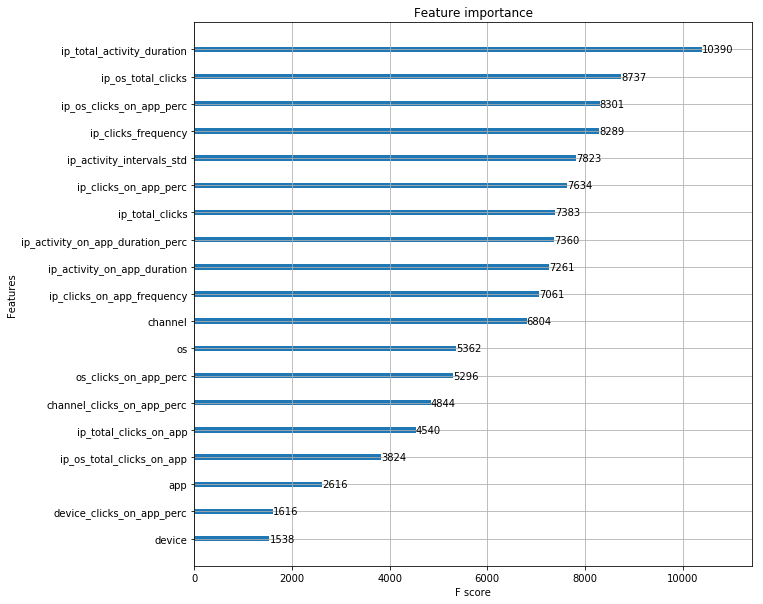

In [13]:
_, ax = plt.subplots(figsize=(10,10))
plot_importance(xgbc, ax=ax)

In [ ]:
del X_train, X_test, y_train, y_test, X, y
gc.collect()